In [1]:
import spatialdata
import scanpy as sc

sdata = spatialdata.read_zarr("/Volumes/ProstateCancerEvo_SpatialAnalysis/dbs/Region_1_Xenium_Phen_HE_Integrated.V9.zarr")
adata = sdata.tables["GeneTranscripts_XStock_PhenCyc_Props_Ann"]
sdata

/Users/ugursahin/miniforge3/envs/SOPA/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
version mismatch: detected: RasterFormatV02, requested: FormatV04
/Users/ugursahin/miniforge3/envs/SOPA/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/Users/ugursahin/miniforge3/envs/SOPA/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/Users/ugursahin/miniforge3/envs/SOPA/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'rea

SpatialData object, with associated Zarr store: /Volumes/ProstateCancerEvo_SpatialAnalysis/dbs/Region_1_Xenium_Phen_HE_Integrated.V9.zarr
├── Images
│     ├── 'HE': DataTree[cyx] (3, 6926, 21997), (3, 3464, 10999), (3, 1731, 5500), (3, 866, 2750), (3, 433, 1375), (3, 216, 687)
│     ├── 'PhenoCycler_Image': DataTree[cyx] (25, 6391, 20981), (25, 3195, 10490), (25, 1597, 5245), (25, 798, 2622), (25, 399, 1311)
│     └── 'Xenium_Image': DataTree[cyx] (5, 17141, 51168), (5, 8570, 25584), (5, 4285, 12792), (5, 2142, 6396), (5, 1071, 3198)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (17141, 51168), (8570, 25584), (4285, 12792), (2142, 6396), (1071, 3198)
│     └── 'nucleus_labels': DataTree[yx] (17141, 51168), (8570, 25584), (4285, 12792), (2142, 6396), (1071, 3198)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 13) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (113273, 1) (2D shapes)
│     ├── 'image_patches': GeoDataFrame shape: (176, 3

In [2]:
import pandas as pd

def get_the_cells(file):
    df = pd.read_csv(file, comment='#')
    return df['Cell ID'].tolist()

# Tumor Enriched
TumorEnriched = get_the_cells("Tumor_Enriched_Region_cells_stats.csv")
TumorFree = get_the_cells("Tumor_Free_Left_cells_stats.csv")
PartialTumor = get_the_cells("Partially_Includes_Tumor_Cells_cells_stats.csv")

In [3]:
#Mesenchymal Attempt

adata.obs['cell_type_manuel'] = (
    adata.obs['cell_type_manuel']
        .str.replace(" ", "_", regex=False)
        .str.replace("/", "OR",   regex=False)
        .str.replace(",", "AND",   regex=False)
        .str.replace("+", "",   regex=False)
        .str.replace(")", "_",   regex=False)
        .str.replace("(", "_",   regex=False)

)


def callCelltypesFromRegions(cell_type_key, inputs = {"Tumor_Enriched":TumorEnriched, "TumorFree":TumorFree, "PartialTumor": PartialTumor}):


    CellAdata = adata[adata.obs["cell_type_manuel"] == cell_type_key]


    databases = []


    for Key, Values in inputs.items():
        databases.append(CellAdata[CellAdata.obs["cell_id"].isin(Values),:].copy())

    # 1) Concatenate the three Mesenchymal subsets into one AnnData
    adata_concat = sc.concat(
        databases,
        axis=0,
        join="inner",                # keep only shared variables
        label="subset",              # name of the new obs‐column
        keys=list(inputs.keys()),
        merge="same"                 # assume var‐ and obsm‐entries are identical
    )

    return adata_concat






In [8]:
set(adata.obs["cell_type_manuel"])

{'Acinar_or_Ductal_Epithelia',
 'B_Lymphocytes__CD20_and_CD68__OR_Plasma_Mucosal_Lymphoid',
 'CD4_T_Cells__Half_of_Group_has_CD4AND_Other_half_CD8_and_CD45_All_',
 'Fibroblast_or_Mesenchymal_OR_stromal_cell_2',
 'Follicular_Dendritic__has_aSMA__OR_mature_B_cell',
 'Glandular_Epithelia__SureAND_NF-H_',
 'Intercalated_Ducts_OR_Cells',
 'Luminal_Epithelial__SureAND_Keratin8OR18__1',
 'Luminal_Epithelial__SureAND_Keratin8OR18__2',
 'Luminal_Secretory_Cells__SureAND_E-cadherin__Keratin8OR18__3',
 'Macrophages_M2_Like__For_sure_CD68_',
 'Mesenchymal_OR_stromal_cell_1',
 'Pericytes_or_Vascular_Endothelial_2_or_Endotgenous_Progenitor',
 'Plasmacytoid_dendritic_cells_or_B_cell_memory__CD31_positive_as_well_',
 'Smooth_muscle_cell_OR_myofibroblast',
 'Synaptic',
 'Tumor',
 'Tumor_-_StemCell_Like',
 'Tumor_divergent',
 'Urethelial_Cells',
 'Vascular_Endothelial_1__CD31_and_CD34_both_groups_'}

In [78]:
# "Vascular_Endothelial_1__CD31_and_CD34_both_groups_"
# "Pericytes_or_Vascular_Endothelial_2_or_Endotgenous_Progenitor"
# "Glandular_Epithelia__SureAND_NF-H_"


# JUST CHANGE IT TO GO !!!!
GroupOfInterest = "CD4_T_Cells__Half_of_Group_has_CD4AND_Other_half_CD8_and_CD45_All_"

adata_interestedCellSubtype_concat = callCelltypesFromRegions(GroupOfInterest, inputs = {"TumorEnriched":TumorEnriched, "PartialTumor": PartialTumor})
adata_interestedCellSubtype_concat


AnnData object with n_obs × n_vars = 1600 × 5101
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'DAPI_PhenCyc', 'CD8_PhenCyc', 'CD31_PhenCyc', 'CD11c_PhenCyc', 'CD34_PhenCyc', 'CD20_PhenCyc', 'CD4_PhenCyc', 'CD21_PhenCyc', 'Ki67_PhenCyc', 'CD68_PhenCyc', 'E_cadherin_PhenCyc', 'pten_PhenCyc', 'NF-H_PhenCyc', 'FOXp3_PhenCyc', 'CD45_PhenCyc', 'TFAM_PhenCyc', 'PDL-1_PhenCyc', 'SOX2_PhenCyc', 'Vimentin_PhenCyc', 'HIF1A_PhenCyc', 'CD44_PhenCyc', 'Keratin_8_18_PhenCyc', 'aSMA_PhenCyc', 'EpCAM_PhenCyc', 'K14_PhenCyc', 'area', 'centroid-0', 'centroid-1', 'centroid_local-1', 'centroid_weighted_local-0', 'centroid_weighted_local-1', 'euler_number', 'extent', 'feret_diameter_max', 'intensity_max', 'intensity_min', 'intensity_mean', 'solidity', 'eccen

(1600, 2)


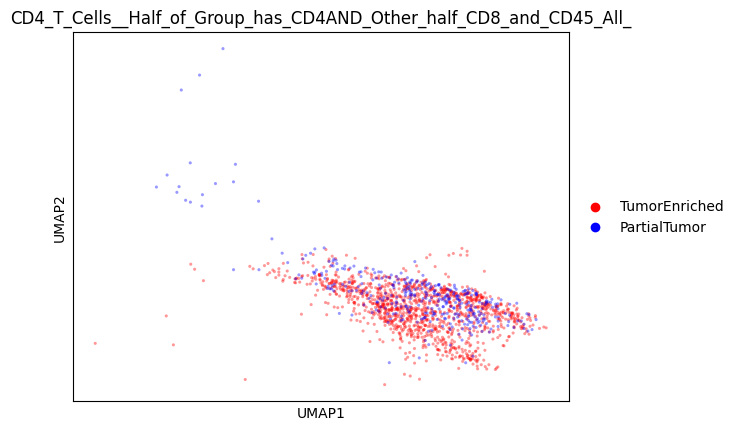

In [79]:
import scanpy as sc


print(adata_interestedCellSubtype_concat.obsm["X_umap"].shape)

# 3) Plot on the precomputed UMAP, colored by subset
sc.pl.umap(
    adata_interestedCellSubtype_concat,
    color="subset",
    palette=["red","blue"],
    size=20,
    title=GroupOfInterest,
    alpha = 0.4
)

In [80]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex

# 1) Extract spatial coords
coords = adata_interestedCellSubtype_concat.obsm['spatial']
x, y = coords[:,0], coords[:,1]

# 2) Build DataFrame with the obs['subset'] labels
df = pd.DataFrame({
    'x': x,
    'y': y,
    'subset': adata_interestedCellSubtype_concat.obs['subset'].astype(str).values
}, index=adata_interestedCellSubtype_concat.obs_names)

# 3) Define a color map for your three subsets
color_map = {
    f'{GroupOfInterest} cells TumorEnriched': 'red',
    f'{GroupOfInterest} cells TumorFree':     'blue',
    f'{GroupOfInterest} cells PartialTumor':  'green'
}

# 4) Plot with Plotly
fig = px.scatter(
    df,
    x='x',
    y='y',
    color='subset',
    color_discrete_map=color_map,
    width=1500,
    height=600,
    title=f"Spatial Scatter of the {GroupOfInterest} cells in given regions"
)
fig.update_traces(marker=dict(size=5, opacity=0.7))
# flip y-axis to match image
fig.update_yaxes(autorange='reversed')
fig.update_layout(legend_title_text='Subset', margin=dict(l=10,r=10,t=40,b=10))

fig.show()

In [81]:
adata_concat = adata_interestedCellSubtype_concat

import scanpy as sc
import gseapy as gp

# 1) Run differential expression: PartialTumor vs TumorEnriched
sc.tl.rank_genes_groups(
    adata_concat,
    groupby='subset',
    groups=['TumorEnriched'],
    reference='PartialTumor',
    method='t-test'          
    
)

# 2) Extract a pre-ranked list of genes (log₂-fold-changes)
de_df = sc.get.rank_genes_groups_df(
     adata_concat,
     group='TumorEnriched',
     key='rank_genes_groups'
)
rnk = de_df.set_index('names')['logfoldchanges']


/Users/ugursahin/miniforge3/envs/SOPA/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning:

invalid value encountered in log2



In [96]:
# 3) Run FGSEA (pre-ranked GSEA) with your gene sets
pre_res = gp.prerank(
    rnk=rnk,
    gene_sets='GO_Biological_Process_2025',    
    processes=4,
    permutation_num=1000,
    outdir=None
)

/var/folders/4p/7h_929nx5qngrf9z7xhfy15w0000gn/T/ipykernel_92193/2031320458.py:2: DeprecationWarning:

processes is deprecated; use threads

2025-05-22 00:30:32,586 [WARNING] Input gene rankings contains NA values(gene name and ranking value), drop them all!
2025-05-22 00:30:32,596 [WARNING] Duplicated values found in preranked stats: 5.05% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [97]:
#pre_res.res2d.sort_values(by="FDR q-val")
pre_res.res2d[pre_res.res2d["FDR q-val"] < 0.05] 

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes


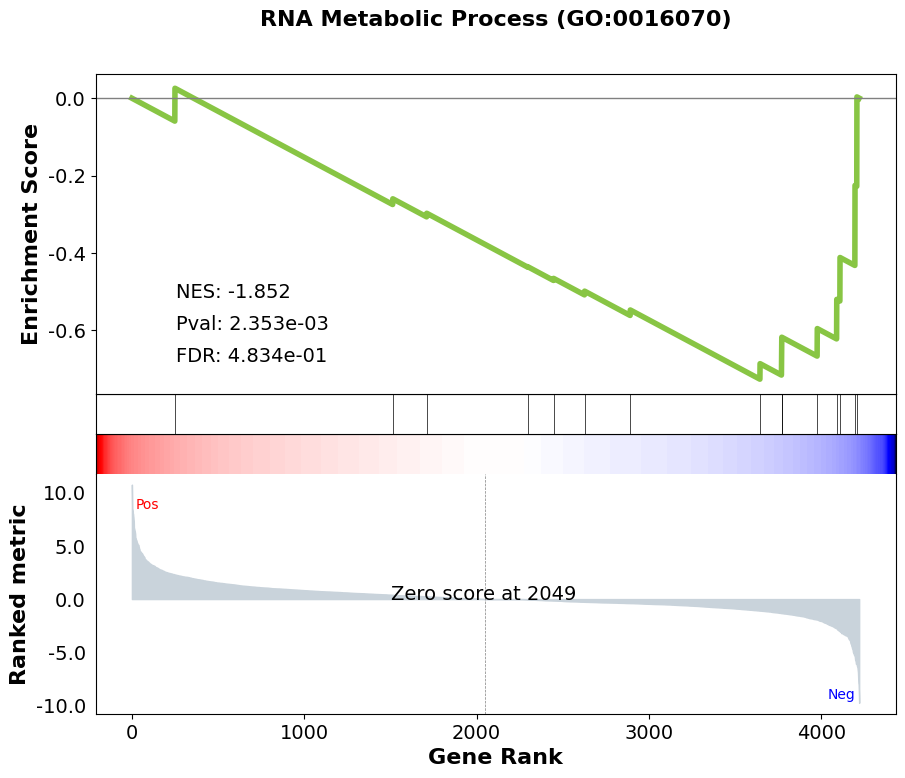

In [98]:
terms = pre_res.res2d.Term
axs = pre_res.plot(terms=terms[0], figsize=(10,8)) # v1.0.5

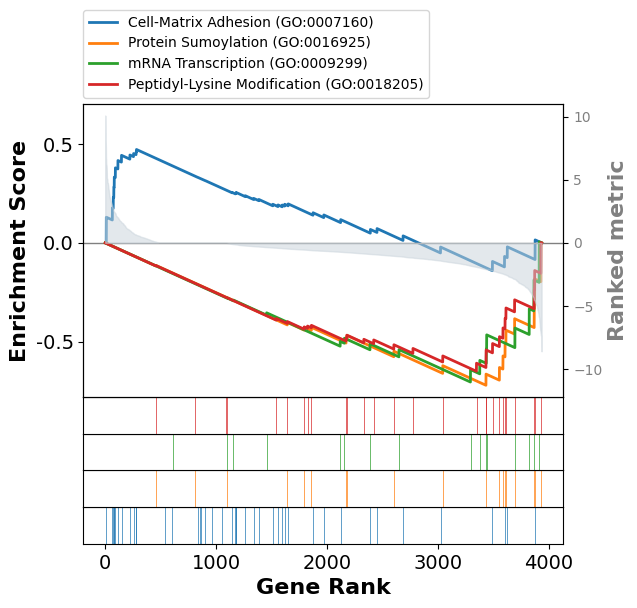

In [77]:
axs = pre_res.plot(terms=[terms[0], terms[1], terms[2], terms[4]],
#legend_kws={'loc': (1.2, 0)}, # set the legend loc
show_ranking=True, # whether to show the second yaxis
figsize=(6,12)
)

In [59]:
import gseapy as gp
# Get a list of all active Enrichr library names (default: Human)
all_libs = gp.get_library_name()

for el in all_libs:
    if "Sig" in el:
        print(el)


DSigDB
Disease_Signatures_from_GEO_down_2014
Disease_Signatures_from_GEO_up_2014
GTEx_Aging_Signatures_2021
GeneSigDB
HDSigDB_Human_2021
HDSigDB_Mouse_2021
LINCS_L1000_CRISPR_KO_Consensus_Sigs
LINCS_L1000_Chem_Pert_Consensus_Sigs
MSigDB_Computational
MSigDB_Hallmark_2020
MSigDB_Oncogenic_Signatures
RNA-Seq_Disease_Gene_and_Drug_Signatures_from_GEO
RNAseq_Automatic_GEO_Signatures_Human_Down
RNAseq_Automatic_GEO_Signatures_Human_Up
RNAseq_Automatic_GEO_Signatures_Mouse_Down
RNAseq_Automatic_GEO_Signatures_Mouse_Up
